# OFC-2 Data Example

Data is freely available and described in detail here: https://crcns.org/data-sets/ofc/ofc-2

I wrote some (somewhat ugly) code to collect the data into a nice format, see `OFC-2-wrangle-data.ipynb`.

### SpikeData

`affinewarp` includes a helper class that encodes high-dimensional spike train data. See `affinewarp/spikedata.py` for the code. Here is a brief overview:

* Spike times are encoded by three 1d arrays: `trials`, `spiketimes`, `neurons`. The arrays are the same length, and hold the number of spikes in the dataset:
```python
len(trials) == len(spiketimes) == len(neurons) = # total number of spikes in the dataset
```
* For the `i`-th spike in the data:
```python
trials[i] = # integer number, the trial that the i-th spike was fired on
spiketimes[i] = # integer number, the time bin of the spike within the trial
neurons[i] = # integer number, the index of the neuron that fired the spike
```
* Given the three arrays listed above, you create the `SpikeData` instance as follows:
```python
data = SpikeData(trials, spiketimes, neurons, tmin, tmax)
```
* The parameters `tmin` and `tmax` specify the beginning and end of each trial. *SpikeData does not throw away spikes occuring outside of this window.* While you can simply `tmin` and `tmax` to `spiktimes.min()` and `spiketimes.max()`, it can be much better to keep some spikes on either end of each trial! When the model warping functions are applied this will allow spikes that were previously outside of the trial boundaries to be warped into view.
* You can access the raw spike times:
```python
data.trials  # returns trial for each spike
data.spiketimes  # returns within-trial time of each spike
data.neurons # returns index of neuron for each spike
```
* You can bin spike times.
```python
binned_data = data.bin_spikes(n_bins)  # returns trials x time x neuron dense numpy array.
```
* And you can do a variety of other things. See:
```
data.reorder_trials(...)
data.reorder_neurons(...)
data.crop_spiketimes(...)
data.select_trials(...)
data.select_neurons(...)
data.shift_each_trial_by_fraction(...)
data.shift_each_trial_by_constant(...)
```

### The models

There are two model classes supported by this library:
```python
model = ShiftWarping(...)  # only shifts each trial
model = PiecewiseWarping(...)  # warps each trial by a piecewise linear warping function.
```

The basic recipe is similar for each model class. The API for both models is inspired by the [`scikit-learn`](http://scikit-learn.org/) library. 
```python
from affinewarp import PiecewiseWarping
model = PiecewiseWarping()
model.fit(binned)
aligned_data = model.transform(data)
```

There are some customizable options in the `PiecewiseWarping` class:
* `n_knots` : integer number of discontinuities in the warping function (default: `n_knots = 0` gives linear warpings).
* `smoothness_reg_scale` : positive number penalizing roughness in the model template. Useful for noisy data, or finely binned spike times.
* `warp_reg_scale` : positive number penalizing scale of the warping functions (distance from identity line). Useful for datasets with small numbers of neurons.
* `l2_reg_scale` : positive number penalizing the amplitude of the model template (like *ridge regression*). Typically, this can be set to a very small number. It prevents numerical instability in the fitting procedure.

To fit a regularized model you simply do:
```python
from affinewarp import PiecewiseWarping
model = PiecewiseWarping(smoothness_reg_scale=10.0, warp_reg_scale=1.0, l2_reg_scale=1e-3)
model.fit(binned)
aligned_data = model.transform(data)
```

### Load data

In [1]:
# See OFC-2-wrangle-data.ipynb for procedure to download and pre-process data #

# load data
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import deepdish as dd
ofc2 = dd.io.load('ofc2_data.h5')

# spike times 
trials = ofc2['trials']
times = ofc2['times']
neurons = ofc2['neurons']

# dict holding trials specific data
#    - metadata['water_on'] gives the time that the reward water turned on each trial
metadata = ofc2['metadata']

### Bin Spikes

In [2]:
from affinewarp import SpikeData

data = SpikeData(trials, times, neurons, tmin=0.0, tmax=6e4)

n_bins = 100
binned = data.bin_spikes(n_bins)
n_trials = binned.shape[0]

### Visualize spike trains aligned to the start of each trial.

See `affinewarp.visualization` for other helper functions. We will visualize the time that water is dispensed on each trial as a red dot. The data are not initially aligned to this event.

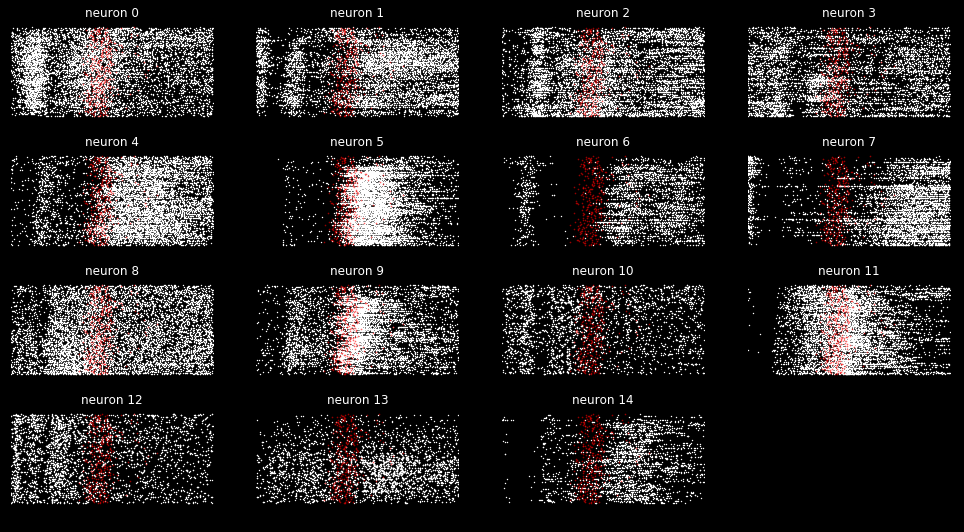

In [3]:
from affinewarp.visualization import rasters

fig, axes = rasters(data, subplots=(4, 4), s=2);

# Plot the reward time for each trial.
for ax in axes.ravel()[:-1]:
    ax.scatter(metadata['water_on'], np.arange(data.n_trials), c='r', s=.5, alpha=.5)

### Fit the model

For a simple look at the data, we will fit a linear warping model (`n_knots = 0`).

Loss improvement: 9.34%: 100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


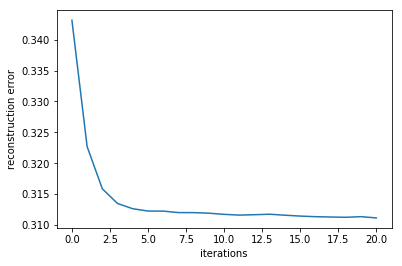

In [4]:
from affinewarp import PiecewiseWarping
model = PiecewiseWarping(n_knots=0)

# fit model and show loss history
model.fit(binned, iterations=20, warp_iterations=20)
plt.plot(model.loss_hist)
plt.xlabel('iterations')
plt.ylabel('reconstruction error');

### Visualize spike trains again, after alignment

Notice that trials naturally align to the water reward onset on each trial. Notice that the `PiecewiseWarping` model was only fit to the neural spike trains, so the alignment of water onset is a highly non-trivial fact. This suggests that manually aligning each trial to other markers (odor onset, trial start, etc.) will cause biased results.

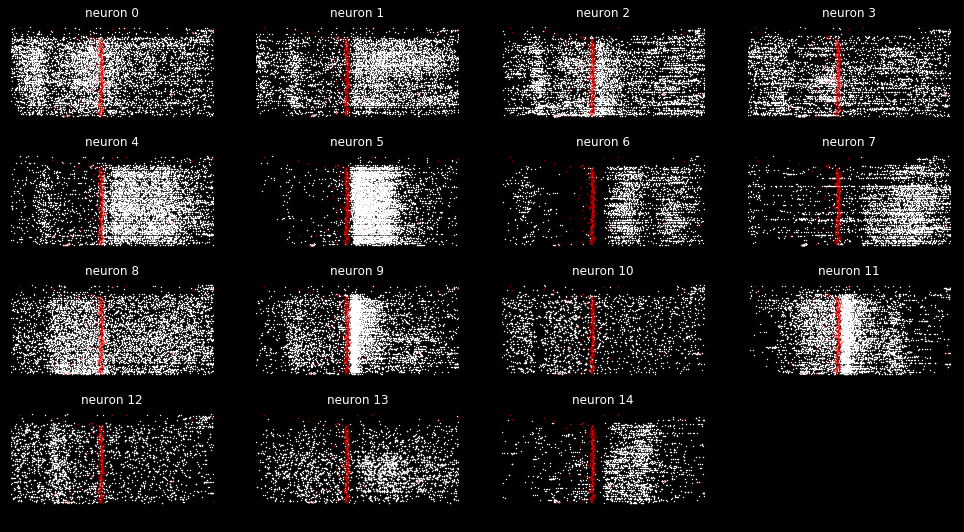

In [5]:
# warp each spike
warped_spikes = model.transform(data)

# warp the onset of reward for each trial
warped_water = 6e4 * model.event_transform(np.arange(data.n_trials), metadata["water_on"] / 6e4)

# plot rasters
fig, axes = rasters(warped_spikes, subplots=(4, 4), s=2);

# plot water onset
K = len(binned)
for ax in axes.ravel()[:-1]:
    ax.scatter(warped_water, np.arange(data.n_trials), c='r', s=.5, alpha=.5)    

# Do nonlinear warps do much better?

We started by fitting a linear warping model. If we increase the complexity of the warping functions by allowing piecewise segments, we see some improvement in model reconstruction. Further analysis could determine whether these benefits correspond to interesting/meaningful structure in the data. Regardless, a linear warping model seems to do quite well and is much easier to interpret.

Loss improvement: 17.14%: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


Text(0, 0.5, 'reconstruction error')

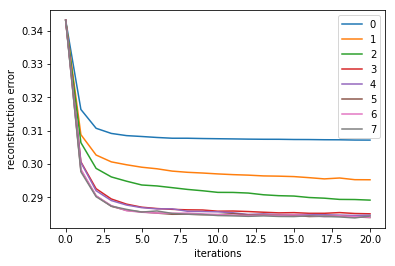

In [6]:
# see if adding more discontinuities to the warping function makes the model fit better.
for knots in range(8):
    model = PiecewiseWarping(n_knots=knots)
    model.fit(binned, iterations=20, warp_iterations=400)
    plt.plot(model.loss_hist, label=knots)
plt.legend()
plt.xlabel('iterations')
plt.ylabel('reconstruction error')